In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Lasso,ElasticNet,Ridge,SGDRegressor
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook

In [2]:
# Load data
data_ft = pd.read_csv('train_features_2013-03-07.csv')
data_sal = pd.read_csv('train_salaries_2013-03-07.csv')

In [3]:
data_ft.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
data_sal.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
print len(data_ft.jobId.unique()),len(data_ft.companyId.unique()), len(data_ft.degree.unique()), len(data_ft.major.unique()), len(data_ft.industry.unique())

1000000 63 5 9 7


In [6]:
# Merge the two tables
data_join = data_ft.merge(data_sal,on='jobId',how='inner')

In [7]:
del data_ft, data_sal

In [8]:
data_join.drop('jobId',inplace=1,axis=1)

In [9]:
data_join.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


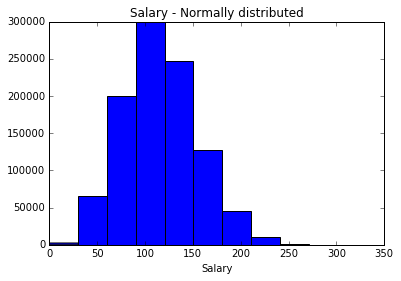

In [10]:
_ = plt.hist(data_join.salary)
plt.title('Salary - Normally distributed')
plt.xlabel('Salary')

In [11]:
data_join.salary.describe()

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

In [12]:
mask = data_join.salary == 0
data_join[mask]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [13]:
data_join = data_join[~mask]

In [14]:
group_company = data_join.groupby('companyId').agg({'salary':'mean'})
print group_company.sort_values('salary').head()
print group_company.sort_values('salary').tail()

               salary
companyId            
COMP53     115.342355
COMP37     115.345049
COMP57     115.393540
COMP42     115.484037
COMP54     115.589785
               salary
companyId            
COMP21     116.539156
COMP13     116.561795
COMP44     116.680892
COMP2      116.759223
COMP40     116.790467


In [15]:
data_join.drop('companyId',inplace=1,axis=1)

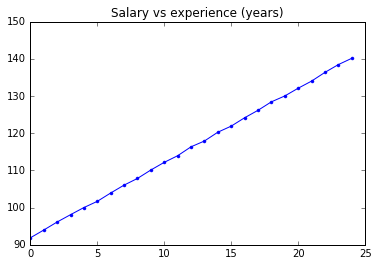

In [16]:
group_exp = data_join.groupby('yearsExperience').agg({'salary':'mean'})
plt.plot(group_exp.index,group_exp.salary,'.-')
plt.title('Salary vs experience (years)')

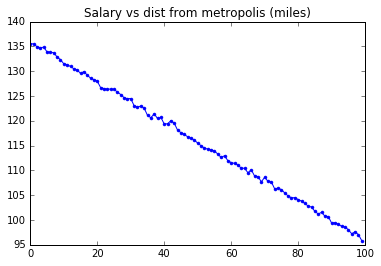

In [17]:
group_miles = data_join.groupby('milesFromMetropolis').agg({'salary':'mean'})
plt.plot(group_miles.index,group_miles.salary,'.-')
plt.title('Salary vs dist from metropolis (miles)')

In [18]:
group_job = data_join.groupby('jobType').agg({'salary':'mean'})
group_job.sort_values('salary')

,salary
jobType,
JANITOR,70.813045
JUNIOR,95.333087
SENIOR,105.487775
MANAGER,115.368518
VICE_PRESIDENT,125.368630
CFO,135.458547
CTO,135.481067
CEO,145.311425


In [19]:
group_degree = data_join.groupby('degree').agg({'salary':'mean'})
group_degree.sort_values('salary')

,salary
degree,
NONE,98.176882
HIGH_SCHOOL,101.921085
BACHELORS,125.454663
MASTERS,130.505647
DOCTORAL,135.490979


In [20]:
group_major = data_join.groupby('major').agg({'salary':'mean'})
group_major.sort_values('salary')

,salary
major,
NONE,102.583864
LITERATURE,124.423097
BIOLOGY,127.932664
CHEMISTRY,129.072085
PHYSICS,130.372436
COMPSCI,132.075605
MATH,133.322042
BUSINESS,135.648980
ENGINEERING,138.441342


In [21]:
group_industry = data_join.groupby('industry').agg({'salary':'mean'})
group_industry.sort_values('salary')

,salary
industry,
EDUCATION,99.448386
SERVICE,104.446820
AUTO,109.435222
HEALTH,115.735540
WEB,121.645362
FINANCE,130.747659
OIL,130.953863


In [22]:
y = data_join['salary']
X = data_join.drop('salary',axis=1)
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size = 0.2, stratify=data_join['major'])

In [23]:
del data_join,X,y

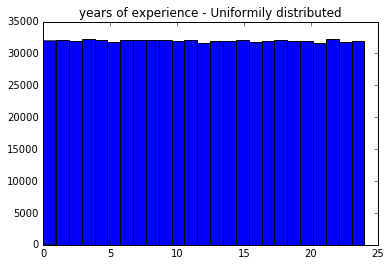

In [24]:
_=plt.hist(train_X.yearsExperience,bins=25)
plt.title('years of experience - Uniformily distributed')

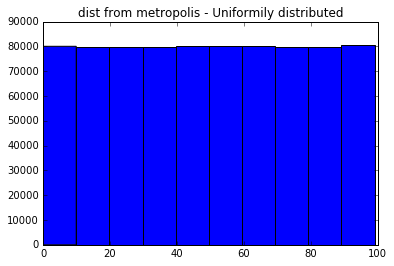

In [25]:
_ = plt.hist(train_X.milesFromMetropolis)
plt.title('dist from metropolis - Uniformily distributed')

In [26]:
class LabelTransformer(object):

    def __init__(self, vars):
        self.vars = vars  # e.g. pass in a column name
        self.lc = LabelEncoder()

    def transform(self, X,y=None):
        return self.lc.transform(X[self.vars])  # transform the feature

    def fit(self, X,y=None):
        self.lc.fit(X[self.vars])  # fit the Label encoder for the specified feature
        
class MinMaxTransformer(object):

    def __init__(self, vars):
        self.vars = vars  # e.g. pass in a column name
        self.minmax = MinMaxScaler()

    def transform(self, X,y=None):
        return self.minmax.transform(X[self.vars].reshape(-1,1))  # transform the feature

    def fit(self, X,y=None):
        self.minmax.fit(X[self.vars].reshape(-1,1))  # fit the MinMaxScaler for the specified feature
        

In [27]:
lt_job = LabelTransformer('jobType')
lt_deg = LabelTransformer('degree')
lt_maj = LabelTransformer('major')
lt_ind = LabelTransformer('industry')

lt_year = MinMaxTransformer('yearsExperience')
lt_miles = MinMaxTransformer('milesFromMetropolis')

In [28]:
lt_job.fit(train_X)
lt_deg.fit(train_X)
lt_maj.fit(train_X)
lt_ind.fit(train_X)

lt_year.fit(train_X)
lt_miles.fit(train_X)

C:\Users\Shetty\Anaconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Shetty\Anaconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
train_X.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
494989,VICE_PRESIDENT,HIGH_SCHOOL,NONE,FINANCE,9,91
941560,MANAGER,MASTERS,BUSINESS,WEB,7,88
646934,CFO,BACHELORS,MATH,SERVICE,0,70
705386,JUNIOR,NONE,NONE,FINANCE,19,68
570686,VICE_PRESIDENT,DOCTORAL,MATH,EDUCATION,16,74


In [30]:
train_X.jobType = lt_job.transform(train_X)
train_X.degree = lt_deg.transform(train_X)
train_X.major = lt_maj.transform(train_X)
train_X.industry = lt_ind.transform(train_X)

train_X.yearsExperience = lt_year.transform(train_X)
train_X.milesFromMetropolis = lt_miles.transform(train_X)

In [31]:
train_X.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
494989,7,2,7,2,0.375000,0.919192
941560,5,3,1,6,0.291667,0.888889
646934,1,0,6,5,0.000000,0.707071
705386,4,4,7,2,0.791667,0.686869
570686,7,1,6,1,0.666667,0.747475


In [32]:
for_dummy_vars = [u'jobType', u'degree', u'major', u'industry']

In [33]:
def getDummy(data,nominal_vars):
    transformed_data = pd.get_dummies(data,columns=nominal_vars)
    
    return transformed_data

In [34]:
train_X = getDummy(train_X,for_dummy_vars)

In [35]:
train_X.head()

,yearsExperience,milesFromMetropolis,jobType_0,jobType_1,jobType_2,jobType_3,jobType_4,jobType_5,jobType_6,jobType_7,...,major_6,major_7,major_8,industry_0,industry_1,industry_2,industry_3,industry_4,industry_5,industry_6
494989,0.375000,0.919192,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
941560,0.291667,0.888889,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
646934,0.000000,0.707071,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
705386,0.791667,0.686869,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
570686,0.666667,0.747475,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [36]:
clf_names = ['Lasso','ElasticNet','Ridge','SGDRegressor','BaggingRegressor','GradientBoostingRegressor']
clfs = [Lasso(),ElasticNet(),Ridge(),SGDRegressor(),BaggingRegressor(),GradientBoostingRegressor()]

In [37]:
results = dict()
for name,clf in zip(clf_names,clfs):
    results[name] = cross_val_score(clf,train_X,train_y,cv=3,n_jobs=1,scoring='mean_absolute_error').mean()

In [38]:
results

{'BaggingRegressor': -17.060876390512345,
 'ElasticNet': -26.410893573068265,
 'GradientBoostingRegressor': -15.651375084200305,
 'Lasso': -18.278900620278396,
 'Ridge': -15.838456250447107,
 'SGDRegressor': -15.842021826758767}

In [39]:
params = dict(alpha = np.logspace(-4, 1, 10), learning_rate = ['optimal','invscaling'])
sgd = SGDRegressor()
clf = GridSearchCV(estimator=sgd,param_grid=params,n_jobs=1)
clf.fit(train_X,train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-04,   3.59381e-04,   1.29155e-03,   4.64159e-03,
         1.66810e-02,   5.99484e-02,   2.15443e-01,   7.74264e-01,
         2.78256e+00,   1.00000e+01]), 'learning_rate': ['optimal', 'invscaling']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [40]:
clf.best_params_

{'alpha': 0.0001, 'learning_rate': 'invscaling'}

In [41]:
clf.best_estimator_

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [42]:
test_X.jobType = lt_job.transform(test_X)
test_X.degree = lt_deg.transform(test_X)
test_X.major = lt_maj.transform(test_X)
test_X.industry = lt_ind.transform(test_X)

test_X.yearsExperience = lt_year.transform(test_X)
test_X.milesFromMetropolis = lt_miles.transform(test_X)

In [43]:
test_X = getDummy(test_X,for_dummy_vars)

In [44]:
test_X.head()

,yearsExperience,milesFromMetropolis,jobType_0,jobType_1,jobType_2,jobType_3,jobType_4,jobType_5,jobType_6,jobType_7,...,major_6,major_7,major_8,industry_0,industry_1,industry_2,industry_3,industry_4,industry_5,industry_6
92232,0.583333,0.565657,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
123580,0.375000,0.626263,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
699180,0.833333,0.757576,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
910477,0.666667,0.404040,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
335174,0.208333,0.616162,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0


In [45]:
salary_pred = clf.best_estimator_.predict(test_X)
mean_absolute_error(test_y,salary_pred)

15.870980385072304

In [46]:
full_train_X = pd.concat((train_X,test_X))
full_train_y = pd.concat((train_y,test_y))

In [47]:
numtrainingpoints = full_train_X.shape[0]

In [48]:
def getrows(chunkrows):
    #print chunkrows
    return full_train_X.iloc[chunkrows],full_train_y.iloc[chunkrows]

In [49]:
def iter_minibatches(chunksize):
    # Provide chunks one by one
    chunkstartmarker = 0
    while chunkstartmarker < numtrainingpoints:
        #print chunkstartmarker,
        if (chunkstartmarker+chunksize) <= numtrainingpoints:
            chunkrows = xrange(chunkstartmarker,chunkstartmarker+chunksize)
        else:
            chunkrows = xrange(chunkstartmarker,numtrainingpoints)
        X_chunk, y_chunk = getrows(chunkrows)
        yield X_chunk, y_chunk
        chunkstartmarker += chunksize

In [50]:
# Resorting to default specs - hoping it will speed up the process
batcherator = iter_minibatches(chunksize=1000)
clf_sgd = clf.best_estimator_

# Train model
for X_chunk, y_chunk in tqdm_notebook(batcherator,desc='Samples trained(in 1000s)',leave=True,total=numtrainingpoints/1000):
    clf_sgd.partial_fit(X_chunk, y_chunk)

In [51]:
test_data = pd.read_csv('test_features_2013-03-07.csv')

In [52]:
test_data = test_data.drop(['jobId','companyId'],axis=1)

In [53]:
test_data.jobType = lt_job.transform(test_data)
test_data.degree = lt_deg.transform(test_data)
test_data.major = lt_maj.transform(test_data)
test_data.industry = lt_ind.transform(test_data)

test_data.yearsExperience = lt_year.transform(test_data)
test_data.milesFromMetropolis = lt_miles.transform(test_data)

In [54]:
test_data = getDummy(test_data,for_dummy_vars)

In [55]:
test_salary_predict = clf_sgd.predict(test_data)

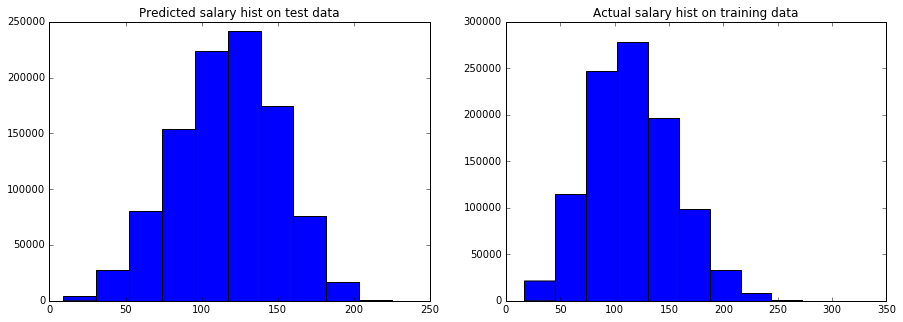

In [56]:
fig = plt.figure(figsize=(15, 5)) 
plt.subplot(1,2,1)
_=plt.hist(test_salary_predict)
plt.title('Predicted salary hist on test data')
plt.subplot(1,2,2)
_=plt.hist(full_train_y)
plt.title('Actual salary hist on training data')

In [57]:
print "Summary salary Stats for test data"
print pd.DataFrame(test_salary_predict).describe()

print "\nSummary Stats for actual salary from train data"
print full_train_y.describe()

Summary salary Stats for test data
                    0
count  1000000.000000
mean       116.636695
std         33.338497
min          9.268247
25%         93.730468
50%        117.985362
75%        140.502236
max        224.993652

Summary Stats for actual salary from train data
count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64


In [58]:
job_id = pd.read_csv('test_features_2013-03-07.csv',usecols=[0])

In [59]:
test_salary_predict_ = pd.DataFrame({'jobId': job_id.values.flatten(), 'salary':test_salary_predict})
test_salary_predict_.to_csv('test_salaries.csv',index=False)

In [64]:
print clf_sgd.coef_

[ 48.24136898 -39.40965115  36.1970325   26.11663187  26.44656219
 -26.12354465 -13.60251351   6.21380982  -3.82249639  16.19693071
  13.54176752  23.64224499   7.75609867  18.50992638   4.17237501
   5.03830525  12.63892826   6.46061301   9.11041416  15.68159666
   1.21785506   9.96365385   0.20891227   7.30213403   3.25810913
  -7.09114616  24.32912367   9.60588467  24.51626188  -1.98352526
  14.98770462]


In [66]:
print full_train_X.columns.values

['yearsExperience' 'milesFromMetropolis' u'jobType_0' u'jobType_1'
 u'jobType_2' u'jobType_3' u'jobType_4' u'jobType_5' u'jobType_6'
 u'jobType_7' u'degree_0' u'degree_1' u'degree_2' u'degree_3' u'degree_4'
 u'major_0' u'major_1' u'major_2' u'major_3' u'major_4' u'major_5'
 u'major_6' u'major_7' u'major_8' u'industry_0' u'industry_1' u'industry_2'
 u'industry_3' u'industry_4' u'industry_5' u'industry_6']
